<a href="https://colab.research.google.com/github/JasonLiu2024/MRI_project/blob/master/Project_Colab_230409.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reference: 
# 1. https://neptune.ai/blog/google-colab-dealing-with-files "Accessing Google Drive from Google Colab"
# 2. https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm <- TopLeftButton, change runtime type, GPU
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
# PyTorch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import torch.nn.functional as F
# other imports
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import scipy
import copy
from numpy import random

## **01: Load data**

In [2]:
# Class: h5py_Dataset
# Reference: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
"""partition: dictionary of {set of IDs} for train, partition, validation"""
"""labels: dictionary, contain index of labels y, given index of input X"""
"""Dataset class, derived from: PyTorch's Dataset"""
def Load_h5py(DATA):
    # load data
    with h5py.File(DATA, 'r') as hdf:
        keys = list(hdf.keys())
        trnOrg = hdf.get('trnOrg')
        x_GroundTruth = np.array(trnOrg) # <- this is our y
        trnMask = hdf.get('trnMask')
        P_SamplingOperator = np.array(trnMask)
    # Formula: y = P*Fourier(x) + e <- e = 0 here!
    y_NoisyMeasurement = P_SamplingOperator * np.fft.fft2(x_GroundTruth) + 0
    # Formula: x_hat = InverseFourier(y)
    x_hat_ZeroFilledImg = np.fft.ifft2(y_NoisyMeasurement) # <- this is our X
    return x_hat_ZeroFilledImg, x_GroundTruth
def Complex_to_2_Channel(image):
    # image = 2d numpy array, shape = (m, n) <- 1 channel
    real = image.real
    imag = image.imag
    return np.dstack([real, imag]) # <- shape = (m, n, 2) <- 2 channel
def ndarray_Complex_to_2_Channel(array): # input form: [count, height, width]
    count = array.shape[0]
    H = array.shape[1]
    W = array.shape[2]
    split = torch.zeros(size=(count, 2, H, W))
    for c in range(count):
      split[c] = ToTensor()(Complex_to_2_Channel(array[c]))
    return split
class h5py_Dataset(torch.utils.data.Dataset):
    # initialize:
    def __init__(self, subset_X_IDs, y_IDs, augmented_X, augmented_y):
        # subset_X_IDs: e.g. only use mth to nth examples to train
        self.subset_X_IDs = subset_X_IDs
        self.y_IDs = y_IDs
        self.X, self.y = augmented_X, augmented_y
    # length: number of elements in subset of X_IDs
    def __len__(self):
        return len(self.subset_X_IDs)
    # get item by index in [m, n]
    def __getitem__(self, index): # assume index lies within subset_X_IDs
        ID = self.subset_X_IDs[index]
        # pick out X & y
        X_pick = self.X[ID]
        y_pick = self.y[ID]
        return X_pick, y_pick
def ShowTensorImage(tensor): # Neural network output is of the form [N, C, H, W]
    if(tensor.dim() > 3):
       tensor = tensor.squeeze(0) # remove first dimension if dim = 4
    numpy = tensor.detach().numpy() # convert to numpy array, form [C, H, W]
    return np.sqrt(numpy[0]**2 + numpy[1]**2)
def Augmentation_Compare(before, after, after_content):
  fig = plt.figure(figsize=(12, 12))
  rows = 1
  columns = 2
  
  fig.add_subplot(rows, columns, 1)
  plt.imshow(ShowTensorImage(before))
  plt.axis('off')
  plt.title(after_content + ": " + str(after.shape))

  fig.add_subplot(rows, columns, 2)
  plt.imshow(ShowTensorImage(after))
  plt.axis('off')
  plt.title("original image: " + str(after.shape))

In [3]:
# load raw data
X_raw, y_raw = Load_h5py("gdrive/MyDrive/Jason_StudentProject/my_data/dataset.hdf5")
print(f"shape of raw data: {X_raw.shape}")
X_split = ndarray_Complex_to_2_Channel(X_raw)
y_split = ndarray_Complex_to_2_Channel(y_raw)
N_raw = X_split.shape[0]
C = X_split.shape[1]
H = X_split.shape[2]
W = X_split.shape[3]
print(f"shape of raw tensor [N, C, H, W]: {X_split.shape}")

shape of raw data: (360, 256, 232)
shape of raw tensor [N, C, H, W]: torch.Size([360, 2, 256, 232])


In [4]:
"""Augmentation: perspective"""
# the original version of transforms work on shallow copy (and messes with before-after comparisons!)
# the randomized version of transforms create deep copy and transforms the deep copy
perspective_X = copy.deepcopy(X_split)
perspective_y = copy.deepcopy(y_split)
for c in range(N_raw):
    params = T.RandomPerspective(p=1).get_params(width=W, height=H, distortion_scale=1)
    perspective_X[c] = T.functional.perspective(img=perspective_X[c], 
                                                startpoints=params[0], 
                                                endpoints=params[1])
    perspective_y[c] = T.functional.perspective(img=perspective_y[c], 
                                                startpoints=params[0], 
                                                endpoints=params[1])
"""Augmentation: rotate"""
rotate_X = copy.deepcopy(X_split)
rotate_y = copy.deepcopy(y_split)
for c in range(N_raw):
    degrees = np.random.randint(90) # only need to randomize one number, so just use base transform
    rotate_X[c] = T.functional.rotate(img=rotate_X[c], angle=degrees)
    rotate_y[c] = T.functional.rotate(img=rotate_y[c], angle=degrees)
"""Augmentation: flip"""
flip_X = copy.deepcopy(X_split)
flip_y = copy.deepcopy(y_split)
for c in range(N_raw):
    flip = np.round(np.random.rand()) # only need to randomize one number, so just use base transform
    flip_X[c] = torch.flip(flip_X[c], [0,1])
    flip_y[c] = torch.flip(flip_y[c], [0,1])
X_combined = torch.cat([X_split, perspective_X, rotate_X, flip_X])
y_combined = torch.cat([y_split, perspective_y, rotate_y, flip_y])
N = X_combined.shape[0]

In [5]:
random_indices = torch.randperm(N)
X_shuffled = X_combined[random_indices]
y_shuffled = y_combined[random_indices]

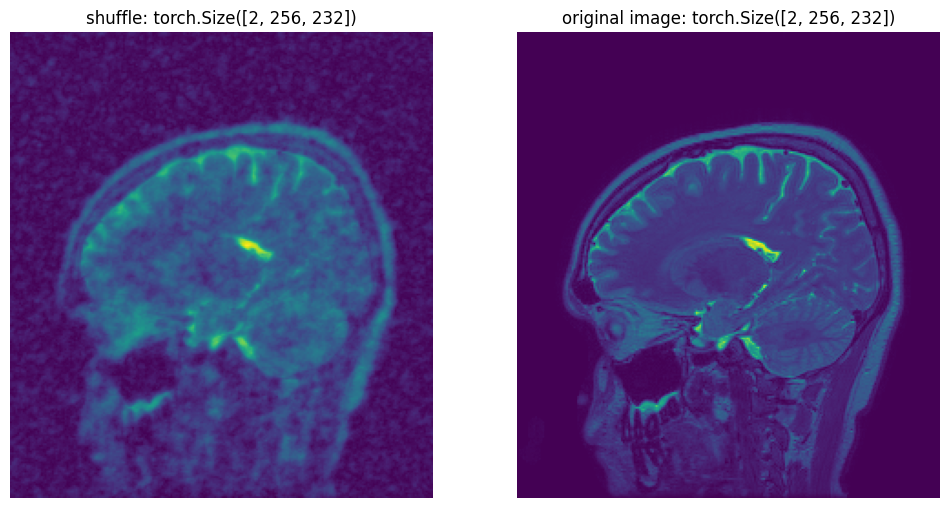

In [6]:
i = int(random.rand()*N)
Augmentation_Compare(X_shuffled[i], y_shuffled[i], "shuffle")

torch.float32


Text(0.5, 1.0, 'a testing data sample: torch.Size([2, 256, 232])')

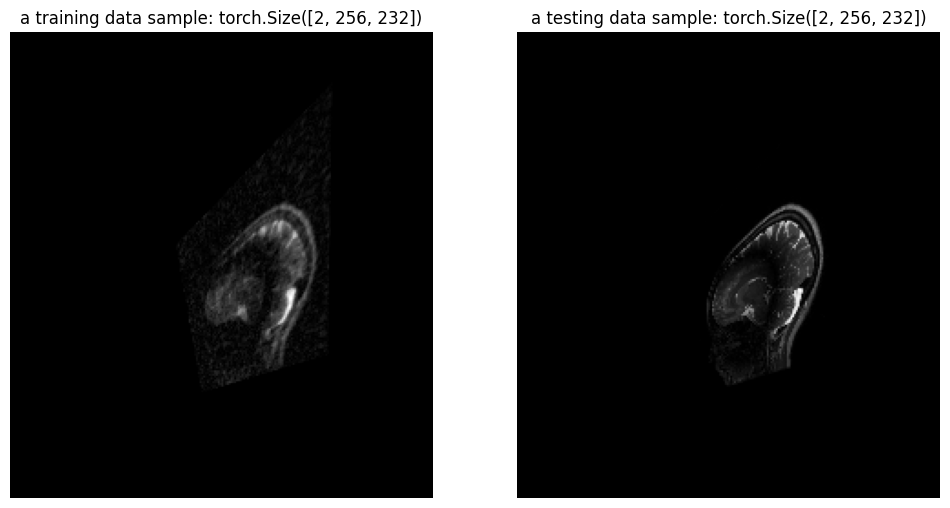

In [7]:
LocalData = "my_data/dataset.hdf5"
CollabData = "gdrive/MyDrive/Jason_StudentProject/my_data/dataset.hdf5"
# partition data
training_ct = int(N * 0.75)
validate_ct = int(N * 0.05)
test_ct = int(N * 0.2)
dev_ct = 1
partition = {
    'train': list(range(dev_ct)),
    'validate': list(range(training_ct, training_ct + validate_ct)),
    'test': list(range(training_ct + validate_ct, N))
}
labels = list[range(0, N)]
# I put dataset dataset.hdf5 in folder 'my_data'
train_dataset = h5py_Dataset(subset_X_IDs=partition['train'],
                            y_IDs=labels,
                            augmented_X=X_shuffled,
                            augmented_y=y_shuffled)
test_dataset = h5py_Dataset(subset_X_IDs=partition['test'],
                            y_IDs=labels,
                            augmented_X=X_shuffled,
                            augmented_y=y_shuffled)
# Testing 'h5py_Dataset' class
fig = plt.figure(figsize=(12, 12))
rows = 1
columns = 2
x1, y1 = train_dataset.__getitem__(0)
print(x1.dtype)
# to show images, I use absolute value
fig.add_subplot(rows, columns, 1)
plt.imshow(np.sqrt(x1[0]**2 + x1[0]**2), cmap = 'gray')
plt.axis('off')
plt.title("a training data sample: " + str(x1.shape))
# for each pixel a + bi, I show sqrt(a**2 + b**2)
fig.add_subplot(rows, columns, 2)
plt.imshow(np.sqrt(y1[0]**2 + y1[0]**2), cmap = 'gray')
plt.axis('off')
plt.title("a testing data sample: " + str(y1.shape))

## **01.5 Data Augmentation**

In [125]:
# Reference: https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be
# use y1 to test, since it's the good image
img = y1
img.shape

torch.Size([2, 256, 232])

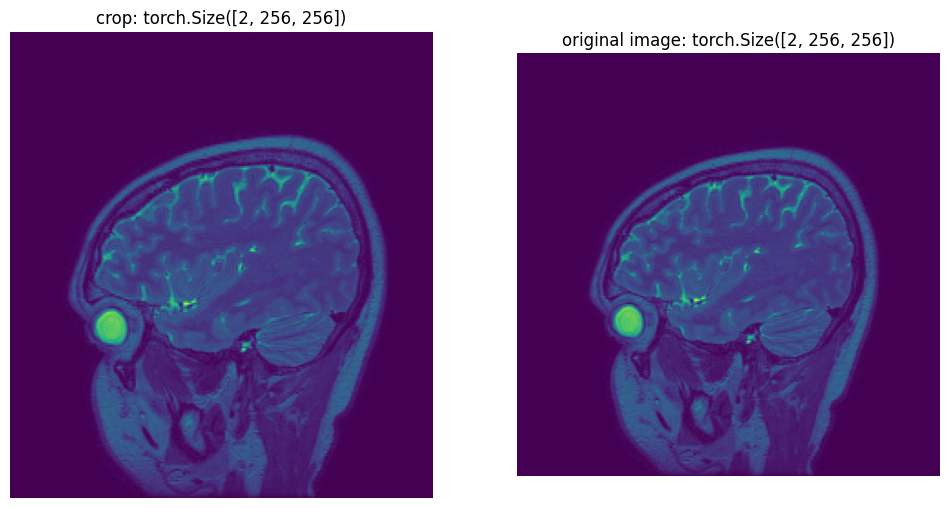

In [ ]:
# crop
# function: CenterCrop()
resize = T.CenterCrop(size=(256, 256))(img)
Augmentation_Compare(img, resize, "crop")
# I make image bigger in case my neural network doesn't work!
# I also use this function for concatenation!

# flip
# function: flip()
flip = torch.flip(img, [1])
Augmentation_Compare(img, flip, "flip")

# rotate
# function: 
rotated = T.RandomRotation(degrees=90)(img) # every time, we can get different rotation!
Augmentation_Compare(img, rotated, "rotated")

# perspective
# p = probability of image being transformed
perspective = T.RandomPerspective(distortion_scale=1, p=1)(img) # we get different image every time!
Augmentation_Compare(img, perspective, "perspective")

## **02: Setup**

In [8]:
batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for X, y in test_dataloader:
    print(f"Shape of X, an image [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y, also an image: {y.shape} {y.dtype}")
    break
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Shape of X, an image [N, C, H, W]: torch.Size([1, 2, 256, 232]) torch.float32
Shape of y, also an image: torch.Size([1, 2, 256, 232]) torch.float32
Using cpu device


In [9]:
# train()
def train(dataloader, model, loss_fn, optimizer):
    print("its testing time!")
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).to(torch.double), y.to(device).to(torch.double) # mod

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# test()
def test(dataloader, model, loss_fn):
    print("it's training time!")
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).to(torch.double), y.to(device).to(torch.double) # mod
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
# Encapsulated: two convolutions, each followed by ReLU
class Conv3x3_Relu_2x(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.go = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.go(x)

class Contract(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.go = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        )
    def forward(self, x):
        return self.go(x)
class Expand(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super().__init__()
        # Reference: https://github.com/pytorch/vision/issues/1708
        self.go = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            # upsampling: just operator, NO param
            # convTransPose: has param, can train
            nn.ConvTranspose2d(out_channels, int(out_channels/2), 
                               kernel_size=(kernel,kernel), stride=2, padding=0)
        )
    def forward(self, x):
        return self.go(x)

In [18]:
# The Neural Network
# Reference:
# https://arxiv.org/pdf/1505.04597.pdf
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
class Me_Net(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Me_Net, self).__init__()
        # n_channels = 2 for MRI image (real & complex part for ea pixel)
        # n_classes: probability distribution for ea pixel. =2 for MRI image
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.CN1 = (Conv3x3_Relu_2x(n_channels, 64))
        # followed by 2x2 max pooling, stride = 2, for downsampling
        self.D1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.CN2 = (Conv3x3_Relu_2x(64, 128))
        self.D2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.CN3 = (Conv3x3_Relu_2x(128, 256))
        self.D3 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.CN4 = (Conv3x3_Relu_2x(256, 512))
        self.D4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) # mod
        self.BOTM = (Conv3x3_Relu_2x(512, 1024))
        # Reference: https://github.com/pytorch/vision/issues/1708
        self.U1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2, padding=0)
        self.EP1 = (Conv3x3_Relu_2x(1024, 512))
        self.U2 = nn.ConvTranspose2d(512, 256, kernel_size=(18,18), stride=2, padding=0)
        self.EP2 = (Conv3x3_Relu_2x(512, 256))
        self.U3 = nn.ConvTranspose2d(256, 128, kernel_size=(18,18), stride=2, padding=0)
        self.EP3 = (Conv3x3_Relu_2x(256, 128))
        self.U4 = nn.ConvTranspose2d(128, 64, kernel_size=(26,26), stride=2, padding=0)
        self.EP4 = (Conv3x3_Relu_2x(128, 64))
        self.out = nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=(1, 1), stride=1)
    def forward(self, input):
        # going down
        CN1 = self.CN1(input) # take 1/2 to concatenate
        print(f"shape of CN1: {CN1.shape}")
        D1 = self.D1(CN1)
        CN2 = self.CN2(D1) # take 1/2 to concatenate
        print(f"shape of CN2: {CN2.shape}")
        D2 = self.D2(CN2)
        CN3 = self.CN3(D2) # take 1/2 to concatenate
        print(f"shape of CN3: {CN3.shape}")
        D3 = self.D3(CN3)
        CN4 = self.CN4(D3) # take 1/2 to concatenate
        print(f"shape of CN4: {CN4.shape}")
        D4 = self.D4(CN4)
        # hit bottom
        BOTM = self.BOTM(D4)
        print(f"bottom: {BOTM.shape}")
        # going up
        U1 = self.U1(BOTM) # need other 1/2
        print(f"shape of U1: {U1.shape}, need {CN4.shape}")
        EP1 = self.EP1(torch.cat([T.CenterCrop(size=(CN4.shape[2], CN4.shape[3]))(U1), CN4], dim=1))
        print(f"before up-conv: {EP1.shape}") 
        U2 = self.U2(EP1) # need other 1/2
        print(f"shape of U2: {U2.shape}, need {CN3.shape}")
        EP2 = self.EP2(torch.cat([T.CenterCrop(size=(CN3.shape[2], CN3.shape[3]))(U2), CN3], dim=1))
        print(f"before up-conv: {EP2.shape}") 
        U3 = self.U3(EP2) # need other 1/2
        print(f"shape of U3: {U3.shape}, need {CN2.shape}")
        EP3 = self.EP3(torch.cat([T.CenterCrop(size=(CN2.shape[2], CN2.shape[3]))(U3), CN2], dim=1))
        print(f"before up-conv: {EP3.shape}") 
        U4 = self.U4(EP3) # need other 1/2
        print(f"shape of U4: {U4.shape}, need {CN1.shape}")
        EP4 = self.EP4(torch.cat([T.CenterCrop(size=(CN1.shape[2], CN1.shape[3]))(U4), CN1], dim=1))
        print(f"before up-conv: {EP1.shape}") 
        logits = self.out(EP4)
        print(f"shape of raw output: {logits.shape}")
        logits_cropped = T.CenterCrop(size=(input.shape[2], input.shape[3]))(logits)
        print(f"shape of cropped output: {logits_cropped.shape}")
        return logits_cropped.to(torch.double)
    
model = Me_Net(n_channels=2,n_classes=2).to(device).to(torch.double)
# print(model)

# Optimization
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)

In [ ]:
t = torch.zeros(size=(1, 2, H, W)).to(torch.double)
model(t)

shape of CN1: torch.Size([1, 64, 252, 228])
shape of CN2: torch.Size([1, 128, 122, 110])
shape of CN3: torch.Size([1, 256, 57, 51])
shape of CN4: torch.Size([1, 512, 24, 21])
bottom: torch.Size([1, 1024, 18, 15])
shape of U1: torch.Size([1, 512, 40, 34]), need torch.Size([1, 512, 24, 21])
before up-conv: torch.Size([1, 512, 20, 17])
shape of U2: torch.Size([1, 256, 56, 50]), need torch.Size([1, 256, 57, 51])
before up-conv: torch.Size([1, 256, 53, 47])
shape of U3: torch.Size([1, 128, 122, 110]), need torch.Size([1, 128, 122, 110])
before up-conv: torch.Size([1, 128, 118, 106])


In [ ]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model.to(torch.double), loss_fn, optimizer)
    test(test_dataloader, model.to(torch.double), loss_fn)
print("Done!")

In [63]:
model_name = "model_banilla.pth"
model_path = f"/content/gdrive/MyDrive/Jason_StudentProject/{model_name}" 
torch.save(model.state_dict(), model_path)
print(f"Saved PyTorch Model State to {model_name}")

Saved PyTorch Model State to model_banilla.pth


In [64]:
model = Me_Net(2,2)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [65]:
model.eval()

Me_Net(
  (CN1): Conv3x3_Relu_2x(
    (go): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (D1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CN2): Conv3x3_Relu_2x(
    (go): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (D2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CN3): Conv3x3_Relu_2x(
    (go): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (D3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CN4): Conv3x3_Relu_2x(
    (go): Sequential(
      (0): Conv2d(256, 512

In [66]:
x_view = test_dataset[0][0].to(torch.float32)[None,:]
y_view = test_dataset[0][1].to(torch.float32)[None,:]
x_view.shape

torch.Size([1, 2, 256, 232])

In [67]:
pred = model(x_view.to(torch.float32))

Text(0.5, 1.0, 'actual image: torch.Size([1, 2, 256, 232])')

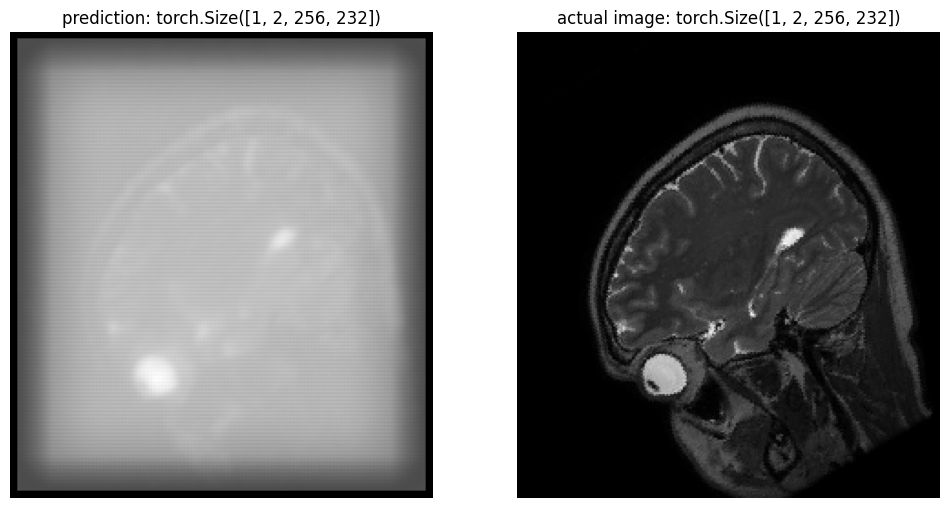

In [71]:
fig3 = plt.figure(figsize=(12, 12))
rows = 1
columns = 2
y1_resize = T.CenterCrop(size=(256, 256))(y1)

fig3.add_subplot(rows, columns, 1)
plt.imshow(ShowTensorImage(pred), cmap = 'gray')
plt.axis('off')
plt.title("prediction: " + str(pred.shape))

fig3.add_subplot(rows, columns, 2)
plt.imshow(ShowTensorImage(y_view), cmap = 'gray')
plt.axis('off')
plt.title("actual image: " + str(y_view.shape))